In [9]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 4
# The step amplitudes in nA. Each amplitude will be run for step_duration
start_amp = 0.0
peak_amp = 2.0
amp_delta = 1.0
step_amplitudes_nA = np.concatenate((np.arange(start_amp, peak_amp, amp_delta), \
                                     np.arange(peak_amp, start_amp-amp_delta/2, -amp_delta)), axis=None) 

neurons_to_stimulate = ["AWAR"]

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

In [10]:
# Setup the model
from model.neural_model import NeuralModel
from util.plot_util import *
import os
import pickle

neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA",
  "AIY",
  "RIM"
])
model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  for neuron in neurons_to_stimulate:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    cur_I_ext[neuron_id] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)

In [11]:
# Run the model. Or not, if cached result already exists
# Cache file is about ~1MB for 1 second.
cache_key = "%d_%.2f_%.2f_%.2f_%s" % \
  (step_duration_s, start_amp, peak_amp, amp_delta, "_".join(neurons_to_stimulate))
cache_path = "../local_results/exp_CHANGING_STEP_AWA/" + cache_key

v_normalized_mat = []
if os.path.isfile(cache_path):
  print("Loading saved results from pickle file {}".format(cache_path))
  with open(cache_path, "rb") as f:
    v_normalized_mat = pickle.load(f)
else:
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)
  # Update cache
  with open(cache_path, "wb") as f:
    pickle.dump(v_normalized_mat, f)

Loading saved results from pickle file ../local_results/exp_CHANGING_STEP_AWA/4_0.00_2.00_1.00_AWAR


# Plot stimulus

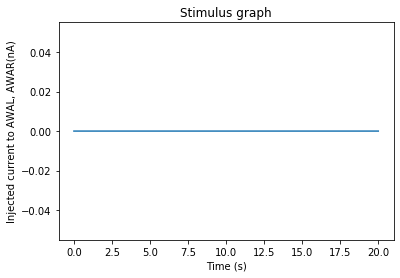

In [12]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))

awal_index = neuron_metadata_collection.get_id_from_name("AWAL")
amps = [time_to_I_ext_fun(time)[awal_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus graph")
ax.set_ylabel("Injected current to AWAL, AWAR(nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


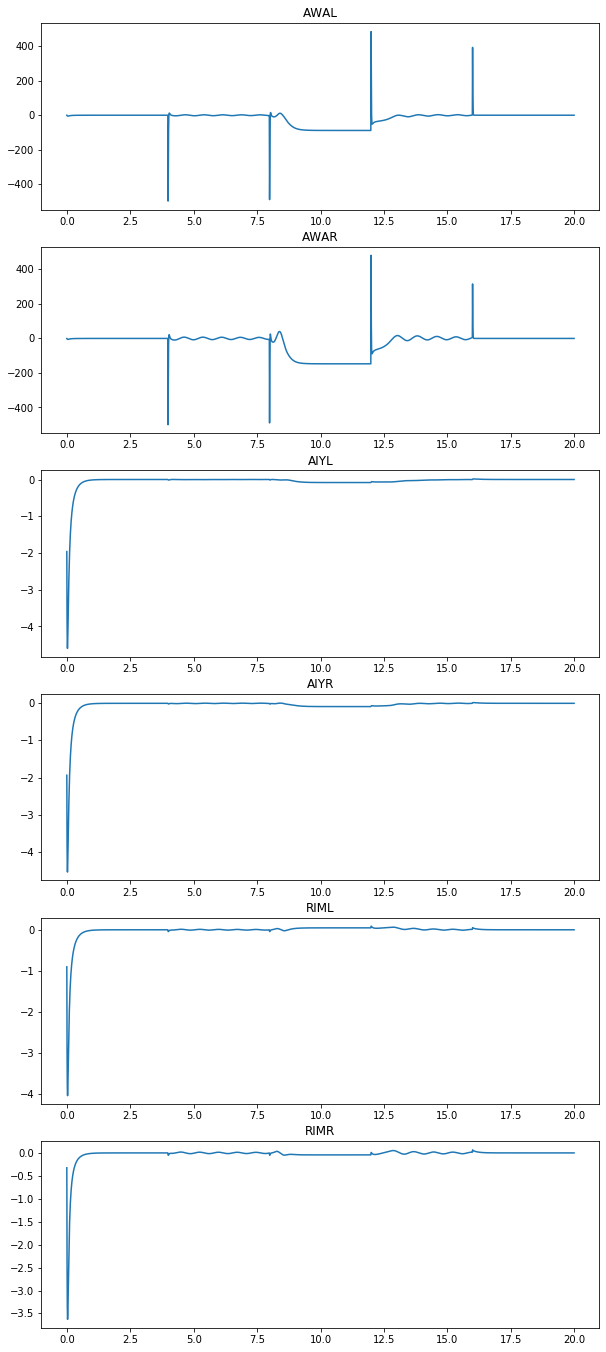

In [13]:
fig = plot_potentials(neurons_to_observe, v_normalized_mat, model.dt, neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

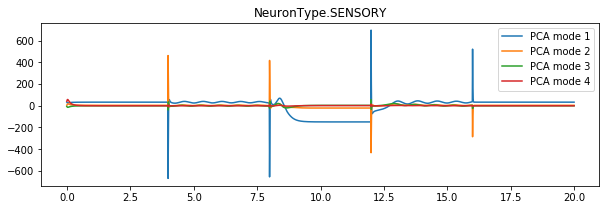

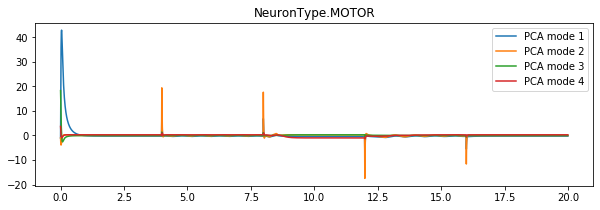

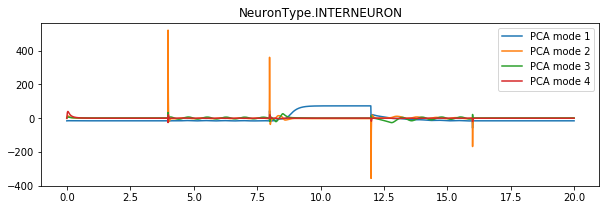

In [14]:
plot_pcas(v_normalized_mat, model.dt, neuron_metadata_collection)

# Bifurcation plot

In [15]:
import util.numpy_util as np_util

# From neuron name to a list of summary statistics of one step of one neuron.
# Each array element is (prev_I, now_I, minV, maxV, meanV)
step_results_per_neuron = {}

for step_amp_i in range(len(step_amplitudes_nA)):
  prev_step_amp_nA = None
  if step_amp_i > 0:
    prev_step_amp_nA = step_amplitudes_nA[step_amp_i-1]
  step_amp_nA = step_amplitudes_nA[step_amp_i]
  timestep_start = int(step_amp_i * step_duration_s / model.dt)
  timestep_end = step_duration_timesteps + timestep_start - 1
  timestep_stable = int(timestep_end - step_duration_timesteps * 0.2)
  stable_traces_for_step = v_normalized_mat[timestep_stable:timestep_end,:]
  for neuron in neurons_to_observe:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    stable_traces_for_neuron = stable_traces_for_step[:, neuron_id]
    minV = min(stable_traces_for_neuron)
    maxV = max(stable_traces_for_neuron)
    meanV = np.mean(stable_traces_for_neuron)
    
    if neuron not in step_results_per_neuron:
      step_results_per_neuron[neuron] = []
    step_results_per_neuron[neuron].append((prev_step_amp_nA, step_amp_nA, minV, maxV, meanV))

# Ascending unique current amplitudes in Na
current_Nas = np.sort(np.unique(step_amplitudes_nA))
# Key = neuron, value = list of statistics, aligned to current_Nas
minVs_per_neuron_asc = {}
maxVs_per_neuron_asc = {}
meanVs_per_neuron_asc = {}
minVs_per_neuron_desc = {}
maxVs_per_neuron_desc = {}
meanVs_per_neuron_desc = {}

for neuron in neurons_to_observe:
  for neuron_to_stats in [minVs_per_neuron_asc, maxVs_per_neuron_asc, meanVs_per_neuron_asc, \
                         minVs_per_neuron_desc, maxVs_per_neuron_desc, meanVs_per_neuron_desc]:
    neuron_to_stats[neuron] = [None] * len(current_Nas)

for neuron in neurons_to_observe:
  # Each array element is (prev_I, now_I, minV, maxV, avgV)
  step_results = step_results_per_neuron[neuron]
  for (prev_I, now_I, minV, maxV, meanV) in step_results:
    min_Vs = minVs_per_neuron_desc[neuron]
    max_Vs = maxVs_per_neuron_desc[neuron]
    mean_Vs = meanVs_per_neuron_desc[neuron]
    if prev_I is None or now_I > prev_I:
      # Ascending case.
      min_Vs = minVs_per_neuron_asc[neuron]
      max_Vs = maxVs_per_neuron_asc[neuron]
      mean_Vs = meanVs_per_neuron_asc[neuron]
    current_Na_aligned_i = np_util.find_nearest_idx(current_Nas, now_I)
    min_Vs[current_Na_aligned_i] = minV
    max_Vs[current_Na_aligned_i] = maxV
    mean_Vs[current_Na_aligned_i] = meanV
  

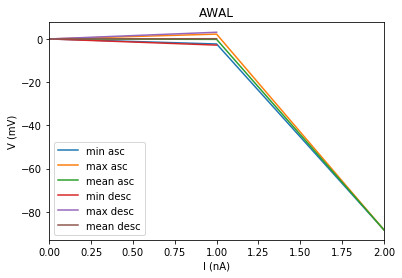

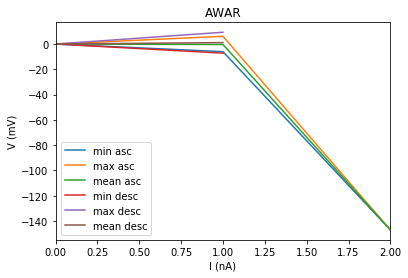

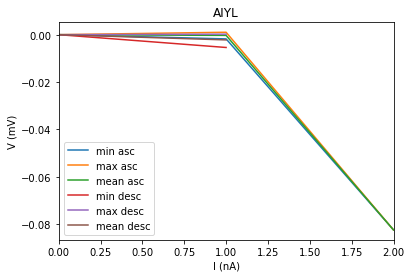

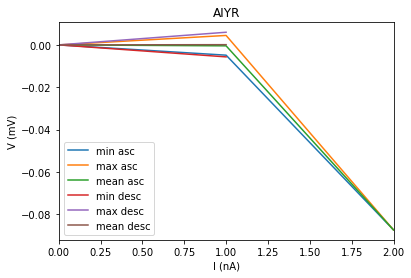

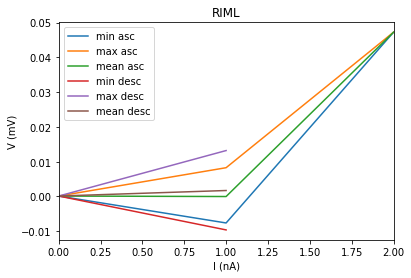

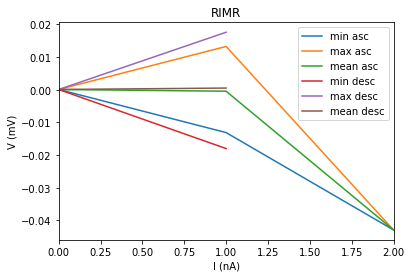

In [16]:
# Plot the summary statistics per neuron
for neuron in neurons_to_observe:
  minVs_per_neuron_asc[neuron]
  maxVs_per_neuron_asc[neuron]
  meanVs_per_neuron_asc[neuron]
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(current_Nas, minVs_per_neuron_asc[neuron], label="min asc")
  ax.plot(current_Nas, maxVs_per_neuron_asc[neuron], label="max asc")
  ax.plot(current_Nas, meanVs_per_neuron_asc[neuron], label="mean asc")
  ax.plot(current_Nas, minVs_per_neuron_desc[neuron], label="min desc")
  ax.plot(current_Nas, maxVs_per_neuron_desc[neuron], label="max desc")
  ax.plot(current_Nas, meanVs_per_neuron_desc[neuron], label="mean desc")
  ax.set_title("%s" % neuron)
  ax.legend()
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")